In [1]:
import matplotlib.pyplot as plt
import os
import gc

import torch
import cv2 as cv
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
import caer
import canaro

2024-02-21 15:00:05.411965: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-21 15:00:06.656562: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 15:00:06.656629: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 15:00:07.108234: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-21 15:00:07.194401: I tensorflow/core/platform/cpu_feature_guar

In [2]:
img_size=(180,180)
channels = 1
char_path= 'Data/simpsons_dataset'

In [3]:
char_dict={}
for char in os.listdir(char_path):
    char_dict[char]=len(os.listdir(os.path.join(char_path,char)))
char_dict = caer.sort_dict(char_dict, descending=True)
char_dict

[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('simpsons_dataset', 42),
 ('agnes_skinner', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('gil', 27),
 ('fat_

In [92]:
chars = []
cnt=0
for i in char_dict:
    chars.append(i[0])
    cnt+=1
    if cnt>=2:
        break
chars

['homer_simpson', 'ned_flanders']

In [93]:
#Создание тренировочных данных
train=caer.preprocess_from_dir(char_path, chars, channels=channels, IMG_SIZE=img_size, isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] 2246 files found in 0.009389638900756836s
[INFO] At 1000 files
[INFO] 1454 files found in 0.0030319690704345703s
----------------------------------------------
[INFO] 3700 files preprocessed! Took 0m 8s


In [94]:
len(train)

3700

<function matplotlib.pyplot.show(close=None, block=None)>

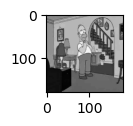

In [95]:
plt.figure(figsize=(1,1))
plt.imshow(train[0][0], cmap='gray')
plt.show

In [96]:
featureSet, labels = caer.sep_train(train, IMG_SIZE=img_size)

In [97]:
featureSet = caer.normalize(featureSet)
labels = to_categorical(labels, len(chars))

In [98]:
x_train, x_val, y_train, y_val = caer.train_val_split(featureSet, labels, val_ratio=0.1)

In [99]:
# x_train.shape
# y_train.shape
# x_val.shape
# y_val.shape

In [100]:
# # Создаем модель нейронной сети
# model = Sequential()

# # Добавляем сверточный слой
# model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(180, 180, 1)))

# # Добавляем слой подвыборки
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

# # Добавляем второй сверточный слой
# model.add(Conv2D(64, (3, 3), activation='relu'))

# # Добавляем второй слой подвыборки
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

# # Преобразуем двумерные данные в одномерные
# model.add(Flatten())

# # Добавляем полносвязный слой
# model.add(Dense(64, activation='relu'))

# # Добавляем выходной слой
# model.add(Dense(3, activation='softmax'))

# # optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.00001, decay=1e-7, momentum=0.7, nesterov=True)

# # Компилируем модель
# # model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()
class ConvNN(tf.keras.Model):
    def __init__(self):
        super(ConvNN, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64,3,activation='relu', input_shape=(180,180,1))
        self.max1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))
        self.conv2 = tf.keras.layers.Conv2D(64,3,activation='relu')
        self.max2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(64, activation='relu')
        self.d2 = tf.keras.layers.Dense(2, activation='relu')

        self.build((None, 180, 180, 1))
    def call(self,x):
        x = self.conv1(x)
        x = self.max1(x)
        x = self.conv2(x)
        x = self.max2(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return x

model = ConvNN()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "conv_nn_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          multiple                  640       
                                                                 
 max_pooling2d_12 (MaxPooli  multiple                  0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          multiple                  36928     
                                                                 
 max_pooling2d_13 (MaxPooli  multiple                  0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         multiple                  0         
                                                                 
 dense_12 (Dense)            multiple                  75

In [112]:
gc.collect()

BATCH_SIZE=32
EPOCHS=3
# if torch.cuda.is_available():
#     print("CUDA доступно на вашем компьютере.")
# else:
#     print("CUDA не доступно на вашем компьютере.")

In [ ]:
datagen = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, height_shift_range=0.1
                             , zoom_range=0.2)
train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

callbacks_list=[LearningRateScheduler(canaro.lr_schedule)]

# optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.00001, decay=1e-7, momentum=0.7, nesterov=True)
# len(x_train)
# len(y_val)

training=model.fit(train_gen, steps_per_epoch=len(x_train)//BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val, y_val),
                   validation_steps=len(y_val)//BATCH_SIZE, callbacks=callbacks_list)
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

Epoch 1/3
  8/104 [=>............................] - ETA: 1:37 - loss: nan - accuracy: 0.6328

In [103]:
val_datagen = canaro.generators.imageDataGenerator()
val_gen = val_datagen.flow(x_val, y_val, batch_size=BATCH_SIZE)
model.evaluate(val_gen)

6/6 [==============================] - 11s 504ms/step - loss: nan - accuracy: 0.6199


[nan, 0.6199460625648499]

<function matplotlib.pyplot.show(close=None, block=None)>

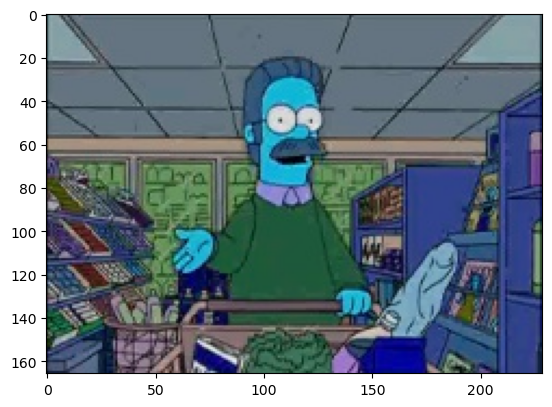

In [107]:
img1 = cv.imread('Data/kaggle_simpson_testset/kaggle_simpson_testset/ned_flanders_15.jpg')
# image = cv.cvtColor(img1, cv.COLOR_RGB2GRAY)
# image = cv.resize(image, (180,180))

def prepare(image, img_size):
    image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    # print(image)
    plt.imshow(image)
    image = cv.resize(image, img_size, interpolation=1)
    image = (image/10).astype('float16')
    image = caer.reshape(image, img_size, 1)
    
    return image
#plt.figure(figsize=(1,1))
plt.imshow(img1, cmap='gray')
plt.show

1/1 [==============================] - 0s 46ms/step


array([[nan, nan]], dtype=float32)

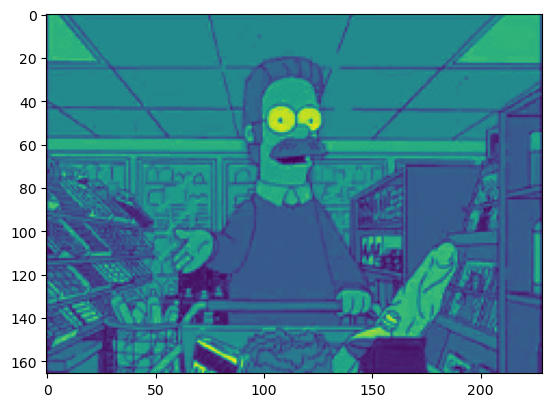

In [110]:
img_size = (180,180)
predictions = model.predict(prepare(img1, img_size))
predictions

In [111]:
print(chars[np.argmax(predictions)])

homer_simpson
